In [4]:
#!pip install parfit
!pip install pydrive

    100% |████████████████████████████████| 993kB 1.1MB/s 
  Running setup.py bdist_wheel for pydrive ... - \ done
  Stored in directory: /content/.cache/pip/wheels/ea/bd/b1/14e948c56cce2c7ac1589346cb54d7efb659fa2ddfa6abba88
Successfully built pydrive


In [0]:
import time

import os
import glob
import re
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sn

from PIL import Image
import skimage.io as ski
from skimage.transform import rescale, resize
import scipy.misc

from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

#import parfit.parfit as pf

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
%matplotlib inline

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Get pickle files
drive.CreateFile({'id': '13rbDW4JpED4Q97AOe1WquZCLCHWb7aI0'}).GetContentFile('train.pkl')
drive.CreateFile({'id': '1gSKWAsH9YND3Y3_vNrXeXa-KRiPEGqBS'}).GetContentFile('test.pkl')
drive.CreateFile({'id': '1wNCJDiwVMnoIL4alHl9De08b337WiEZP'}).GetContentFile('validation.pkl')


In [0]:
#Load pickle files
X = []
Y = []
X_validate = []
Y_validate = []
X_test = []
Y_test = []

label_pairs ={
    'adho_mukha_svanasana':1,
    'bharadvajasana':2,
    'pasasana':3,
    'salamba_sarvangasana':4,
    'salamba_sirsasana':5,
    'virabhadrasana_I':6,
    'virabhadrasana_II':7,
    'virabhadrasana_III':8
}


In [10]:
#Open data files and populate data structures
X_type = 'float64'

with open('train.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X.append(record[0].astype(X_type))
            Y.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Train Data Size :" , len(X))


processing done!
Train Data Size : 6180


In [11]:
with open('validation.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X_validate.append(record[0].astype(X_type))
            Y_validate.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Validation Data Size :" , len(X_validate))

processing done!
Validation Data Size : 1330


In [12]:
with open('test.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X_test.append(record[0].astype(X_type))
            Y_test.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Test Data Size :" , len(X_test))


processing done!
Test Data Size : 265


In [13]:
len(X_test)

265

In [14]:
X_test[0].shape

(64, 64, 3)

In [15]:
X_test[1].shape

(64, 64, 3)

In [0]:
#Convert read files to single matrix (test/train/valid) containing each image as a row

In [17]:
X_train_model_input = np.zeros( (len(X), 64 * 64 * 3) ) 
for index, item in enumerate(X):
  X_train_model_input[index] = X[index].flatten()
X_train_model_input.shape

(6180, 12288)

In [18]:
X_validate_model_input = np.zeros( (len(X_validate), 64 * 64 * 3) )
for index, item in enumerate(X_validate):
  X_validate_model_input[index] = X_validate[index].flatten()
X_validate_model_input.shape

(1330, 12288)

In [19]:
X_test_model_input = np.zeros( (len(X_test), 64 * 64 * 3) )
for index, item in enumerate(X_test):
  X_test_model_input[index] = X_test[index].flatten()
X_test_model_input.shape

(265, 12288)

In [0]:
#Random Forest classifier
parameters = {
    'min_samples_leaf': [1,3,5,10,15,25,50,100,125,150,175,200],
    'max_features': ['sqrt', 'log2', 0.4, 0.5, 0.6, 0.7],
    'n_estimators': [10, 30, 60, 90],
    'n_jobs': [-1],
    'random_state': [42]
}

#random_forest_model = GridSearchCV(RandomForestClassifier(), parameters)
random_forest_model = RandomForestClassifier()
%time random_forest_model.fit(X_train_model_input, Y)

In [0]:
predictedTrain = random_forest_model.predict(X=X_train_model_input)
predictedTest  = random_forest_model.predict(X=X_validate_model_input)

In [61]:
metrics.accuracy_score(np.array(Y_validate), predictedTest)

0.4496240601503759

In [0]:
confmat_test = metrics.confusion_matrix( predictedTest, Y_validate )

In [64]:
pd.DataFrame(confmat_test)

,0,1,2,3,4,5,6,7
0,88,12,8,0,10,14,18,47
1,4,78,26,9,12,15,9,12
2,9,16,48,3,7,8,16,6
3,4,10,8,104,45,13,14,15
4,4,24,10,25,79,11,15,17
5,8,4,10,14,4,42,28,12
6,15,9,8,22,9,18,81,33
7,18,12,7,3,4,4,14,78


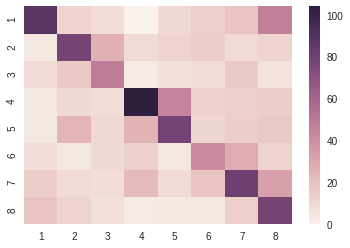

In [67]:
confmat_labels = list(set(Y_validate))
confmat_labels.sort()
sn.heatmap(pd.DataFrame(confmat_test, confmat_labels, confmat_labels))

In [20]:
#SVM classifier

parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
              {'kernel': ['linear'], 'C': [1, 10, 100, 1000]},
              {'kernel': ['poly'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
              {'kernel': ['sigmoid'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]}]

#svm_model = GridSearchCV(estimator=SVC(probability=True), param_grid=parameters)
svm_model = SVC()
%time svm_model.fit(X_train_model_input, Y)

CPU times: user 18min 19s, sys: 621 ms, total: 18min 19s
Wall time: 18min 20s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
svm_predictedTrain = svm_model.predict(X=X_train_model_input)
svm_predictedTest  = svm_model.predict(X=X_validate_model_input)

In [22]:
metrics.accuracy_score(np.array(Y_validate), svm_predictedTest)

0.1556390977443609